#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [ ]:
!pip3 install catboost
!pip install lightgbm

# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm

# модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

# метрика
from sklearn.metrics import mean_squared_error, make_scorer

# расчеты
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score

# константы
RANDOM_STATE = 12345

import warnings
warnings.filterwarnings("ignore")

### Изучение данных

In [ ]:
# Откроем файл
df = pd.read_csv('taxi.csv')

# Изучим основную информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
# Изучим основную информацию о данных
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Посмотрим график распределения количества заказов за весь период исследования, чтобы понять, есть ли явные аномалии.

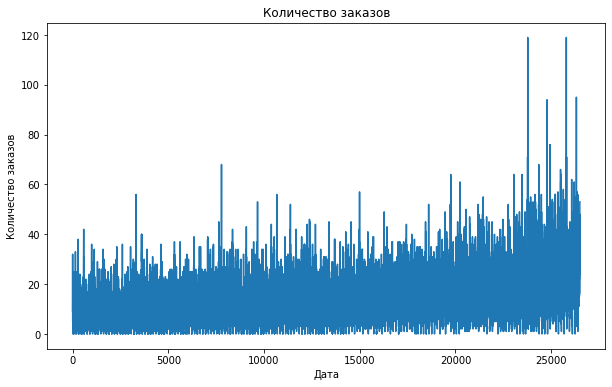

In [ ]:
# Построим график количества заказов
df['num_orders'].plot(figsize=(10, 6), title = 'Количество заказов', legend=False, xlabel='Дата', ylabel='Количество заказов');

**Вывод:** предобработка данных не требуется, пропусков нет, явных аномалий нет. Данные отлично подготовлены к работе.

### Ресемлирование

Заново откроем датасет, при этом переведем первый столбец в формат Datetime и установим его в качестве индекса.

In [ ]:
# Откроем файл
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

# Отсортируем данные по дате
data = data.sort_index()

In [ ]:
# Выполним ресемплирование по 1 часу
data = data.resample('1H').sum()

## Анализ

In [ ]:
# Посмотрим, за какой период данные
display(data.index.min())
display(data.index.max())

Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

В датасете данные представлены за полгода - **с 01 марта 2018 по 31 августа 2018 включительно**. Посмотрим графики в разбивке по месяцам, дням и часам.

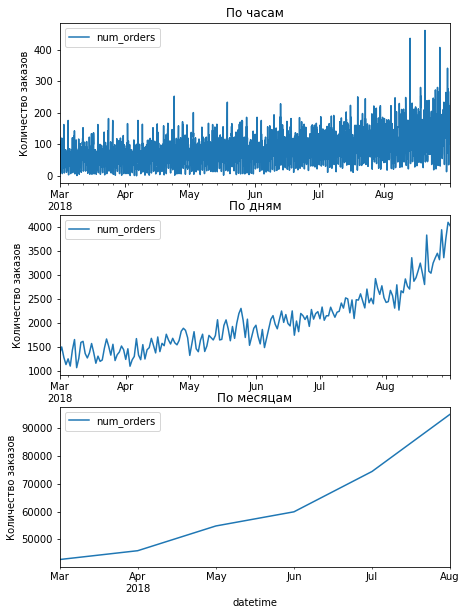

In [ ]:
# Построим графики
plt.figure(figsize=(7,10))

plt.subplot(311)
data.resample('1H').sum().plot(ax=plt.gca())
plt.title('По часам')
plt.ylabel('Количество заказов')

plt.subplot(312)
data.resample('1D').sum().plot(ax=plt.gca())
plt.title('По дням')
plt.ylabel('Количество заказов')

plt.subplot(313)
data.resample('1M').sum().plot(ax=plt.gca())
plt.title('По месяцам')
plt.ylabel('Количество заказов');

В целом видим, что заказов с каждым месяцем становилось все больше, что может объясняться сезоном отпусков. Поскольку данные имеются только за полгода, то сложно сказать, увеличение количества заказов - это тренд или сезонность.

Дополнительно разложим наши данные на тренд и сезонную компоненту с помощью функции seasonal_decompose().

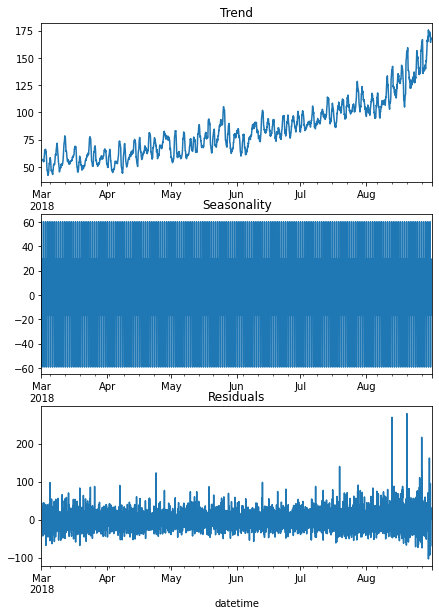

In [ ]:
# Графики тренда и сезонности в разбивке по часам
decomposed = seasonal_decompose(data)

plt.figure(figsize=(7,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

В разбивке по часам графики получились не очень информативные. Попробуем ресемплировать данные по дням.

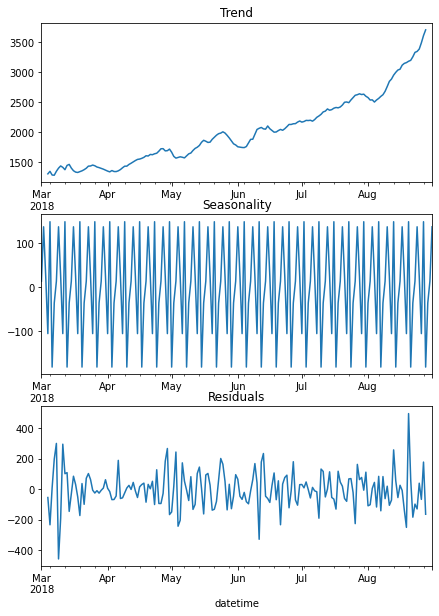

In [ ]:
# Графики тренда и сезонности в разбивке по дням
data_day = data.resample('1D').sum()
decomposed = seasonal_decompose(data_day)

plt.figure(figsize=(7,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

Отдельно проанализируем графики сезонности за более короткий срок - например, за двухнедельный период в марте, мае и августе.

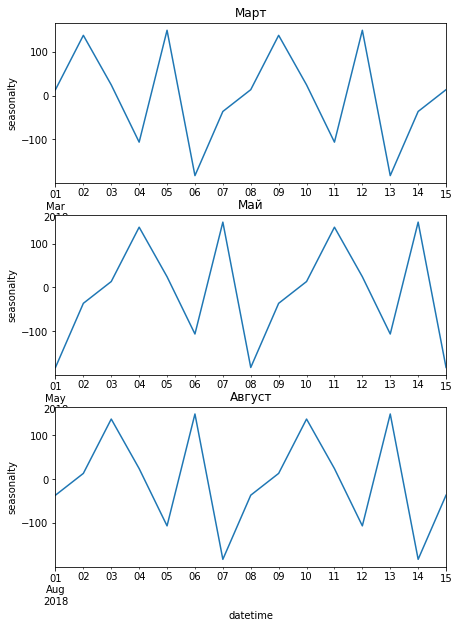

In [ ]:
# Графики сезонности в разбивке по дням
plt.figure(figsize=(7,10))

plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Март')
plt.ylabel('seasonalty')

plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Май')
plt.ylabel('seasonalty')

plt.subplot(313)
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Август')
plt.ylabel('seasonalty');

На всех графиках видна четкая сезонность с интервалом в 7 дней. То есть в определенные дни недели наблюдается большой спрос на услуги такси, в другие дни - наоборот.

Вернемся к анализу данных по часам. Очевидно, что необходимо уменьшить срок для анализа. Возьмем 2 недели августа.

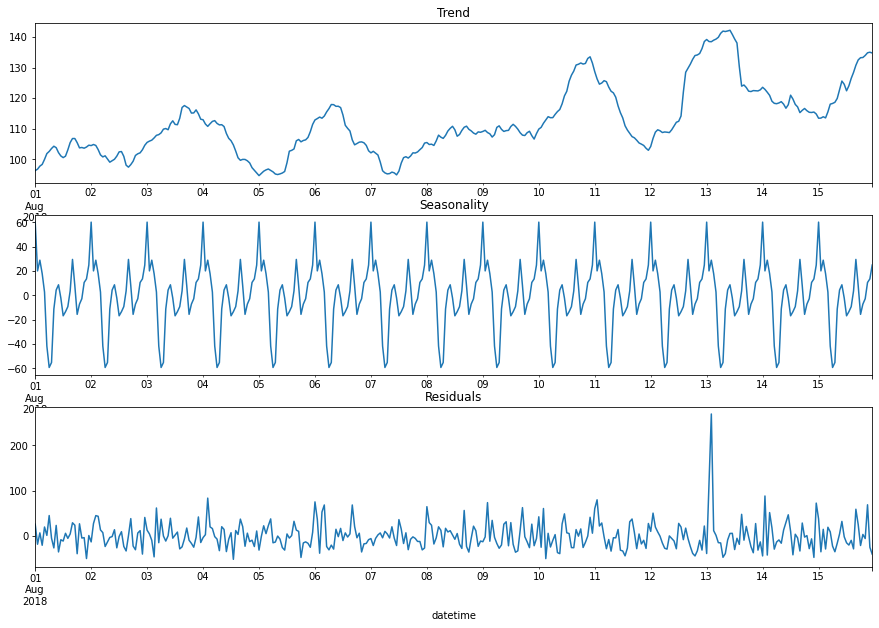

In [ ]:
# Графики тренда и сезонности в разбивке по часам, две недели августа
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Residuals');

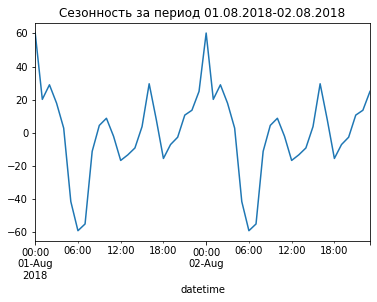

In [ ]:
# График сезонности, 2 дня
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(title='Сезонность за период 01.08.2018-02.08.2018');

На графике видим четкую сезонность по часам - ранним утром число заказов существенно падает, вечером и в ночные часы наблюдается час пик.

Далее построим график скользящего среднего и скользящего стандартного отклонения. Размер окна - 24 часа.


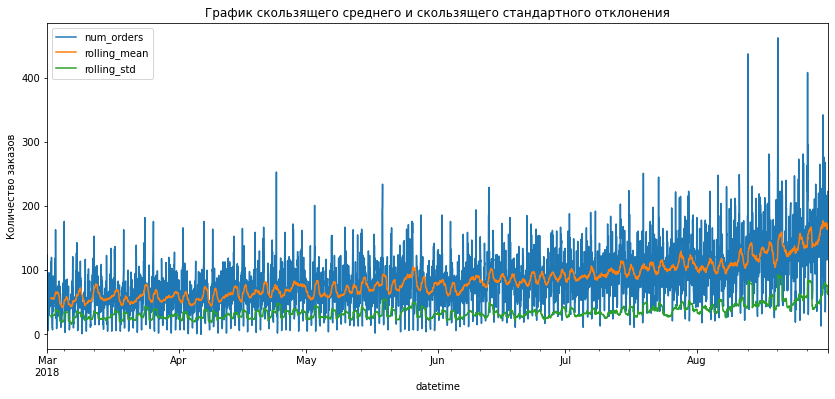

In [ ]:
# Скользящие графики
data_roll = data.copy()
data_roll['rolling_mean'] = data_roll.rolling(24).mean()
data_roll['rolling_std'] = data_roll['num_orders'].rolling(24).std()
data_roll.plot(figsize=(14, 6), ylabel='Количество заказов', title = 'График скользящего среднего и скользящего стандартного отклонения');

В результате видим, что временной ряд **не является стационарным**. Чтобы ряд сделать более стационарным, найдём разности его значений.

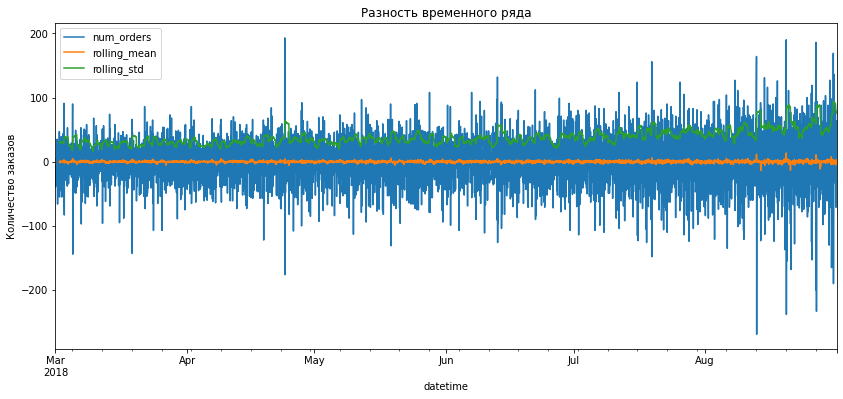

In [ ]:
data_shift = data - data.shift()
data_shift['rolling_mean'] = data_shift.rolling(24).mean()
data_shift['rolling_std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(14, 6), ylabel='Количество заказов', title = 'Разность временного ряда');

**Вывод:**
* в целом данные демонстрируют тренд на увеличение заказов за весь анализируемый период. Но нам не хватает данных, чтобы понимать, вызван ли этот рост сезонностью (летом - сезон отпусков) или другими факторами.
* имеется зависимость количества заказов от дня недели.
* имеется зависимость количества заказов от времени суток - поздней ночью и ранним утром количество заказов минимально, после обеда и до 00:00 спрос на такси высокий.
* временной ряд не является стационарным. Посредством разности значений временного ряда можно преобразовать наш ряд в более стационарный.

## Обучение

### Подготовка признаков

Перед нами стоит задача спрогнозировать количество заказов такси на следующий час. Таким образом, горизонт планирования равен 1 часу. Поскольку спрогнозировать необходимо числа, то перед нами **задача регрессии**.

Перед обучением моделей создадим признаки, для этого напишем функцию `make_features`. Будем добавлять к таблице следующие признаки: месяц, день, день недели и час, поскольку все они влияют на целевой признак, как мы видели выше при анализе.

In [ ]:
# Функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Следующим шагом применим функцию для создания датасета с признаками. Сдвиг возьмем в размере 24 часа, окно - 24 часа.

In [ ]:
# Создадим датасет для обучения и посмотрим результат
df = make_features(data, 24, 24)
df.head()

,num_orders,month,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,1,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,1,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По исходным данным создадим обучающую (train) и тестовую (test) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой.

In [ ]:
# Удалим строки с пропусками
df = df.dropna()

# Разделим данные на 2 выборки: 10% тестовая и 90% обучающая
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# Проверим правильность разбивки
display('Выборка train', train.index.min(), train.index.max())
display('Выборка test', test.index.min(), test.index.max())

'Выборка train'

Timestamp('2018-03-02 00:00:00', freq='H')

Timestamp('2018-08-13 15:00:00', freq='H')

'Выборка test'

Timestamp('2018-08-13 16:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

In [ ]:
# Выделим целевой признак
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Все признаки имеют числовое значение, поэтому кодирование и масштабирование для дальнейшего обучения не требуется. Для расчета RMSE создадим функцию.

In [ ]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Линейная регрессия

При работе с временными рядами нельзя применить кросс-валидацию в привычном виде, но для таких целей можно использовать TimeSeriesSplit().

In [ ]:
# переменная для кросс-валидации
tss = TimeSeriesSplit(n_splits=3)

In [ ]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

linear_rmse = pd.Series(cross_val_score(model_linear, X_train, y_train, scoring=RMSE_score, cv=tss)).mean()*(-1)
print('RMSE линейной регрессии на кросс-валидации:', linear_rmse)

RMSE линейной регрессии на кросс-валидации: 27.564120305188684


### Случайный лес

In [ ]:
%%time
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

parameters = {'n_estimators': range(10, 30, 5),
              'min_samples_leaf': range(1, 5),
              'max_depth': range(10, 15)}

grid_rf = RandomizedSearchCV(model_rf, parameters, cv=tss, scoring=RMSE_score,
                               n_jobs=-1, random_state=RANDOM_STATE)
grid_rf.fit(X_train, y_train)

display('Лучшие параметры случайного леса:', grid_rf.best_params_)
display('RMSE случайного леса на кросс-валидации:', grid_rf.best_score_*(-1))

'Лучшие параметры случайного леса:'

{'n_estimators': 15, 'min_samples_leaf': 3, 'max_depth': 14}

'RMSE случайного леса на кросс-валидации:'

27.709612559783846

CPU times: user 8.76 s, sys: 48.3 ms, total: 8.81 s
Wall time: 8.96 s


### Ridge

In [ ]:
%%time
model_rid = Ridge(random_state=RANDOM_STATE)

parameters_rid = {'alpha': np.arange(0, 0.21, 0.02)}

grid_rid = RandomizedSearchCV(model_rid, parameters_rid, cv=tss, scoring=RMSE_score,
                               n_jobs=-1, random_state=RANDOM_STATE)
grid_rid.fit(X_train, y_train)

display('Лучшие параметры модели Ridge:', grid_rid.best_params_)
display('RMSE модели Ridge на кросс-валидации:', grid_rid.best_score_*(-1))

'Лучшие параметры модели Ridge:'

{'alpha': 0.0}

'RMSE модели Ridge на кросс-валидации:'

27.562524049417515

CPU times: user 1.26 s, sys: 1.92 s, total: 3.18 s
Wall time: 3.14 s


### CatBoost

In [ ]:
%%time
model_cat = CatBoostRegressor(random_state=RANDOM_STATE)

parameters_cat = {'iterations': range(100, 501, 50),
                  'learning_rate': [0.25, 0.3, 0.35, 0.4],
                  'depth': range(2, 6, 1)}

grid_cat = RandomizedSearchCV(model_cat, parameters_cat, cv=tss, scoring=RMSE_score,
                               n_jobs=-1, random_state=RANDOM_STATE)
grid_cat.fit(X_train, y_train, verbose=50)

display('Лучшие параметры CatBoost:', grid_cat.best_params_)
display('RMSE CatBoost на кросс-валидации:', grid_cat.best_score_*(-1))

0:	learn: 24.9272675	total: 54.4ms	remaining: 13.6s
50:	learn: 13.4808191	total: 115ms	remaining: 448ms
100:	learn: 10.1057606	total: 171ms	remaining: 253ms
150:	learn: 8.0245199	total: 231ms	remaining: 151ms
200:	learn: 6.4796535	total: 282ms	remaining: 68.7ms
249:	learn: 5.5123151	total: 332ms	remaining: 0us
0:	learn: 27.7028667	total: 1.71ms	remaining: 426ms
50:	learn: 16.2980811	total: 63ms	remaining: 246ms
100:	learn: 13.9121698	total: 125ms	remaining: 185ms
150:	learn: 12.1111547	total: 202ms	remaining: 133ms
200:	learn: 10.8412199	total: 278ms	remaining: 67.7ms
249:	learn: 9.7086184	total: 349ms	remaining: 0us
0:	learn: 29.3695277	total: 1.79ms	remaining: 445ms
50:	learn: 18.1607596	total: 77.7ms	remaining: 303ms
100:	learn: 16.1734978	total: 159ms	remaining: 235ms
150:	learn: 14.7094003	total: 237ms	remaining: 155ms
200:	learn: 13.5223691	total: 309ms	remaining: 75.4ms
249:	learn: 12.5953229	total: 377ms	remaining: 0us
0:	learn: 26.5490542	total: 889us	remaining: 266ms
50:	lear

'Лучшие параметры CatBoost:'

{'learning_rate': 0.25, 'iterations': 250, 'depth': 3}

'RMSE CatBoost на кросс-валидации:'

26.049532281332176

CPU times: user 15.2 s, sys: 771 ms, total: 16 s
Wall time: 32.6 s


### LightGBM

In [ ]:
%%time
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

parameters_lgbm = {'learning_rate': np.logspace(-1, 0, 1),
                   'n_estimators': range(80, 141, 10),
                   'num_leaves': range(4, 10)}

grid_lgbm = RandomizedSearchCV(model_lgbm, parameters_lgbm, cv=tss, scoring=RMSE_score,
                               n_jobs=-1, random_state=RANDOM_STATE)
grid_lgbm.fit(X_train, y_train, verbose=50)

display('Лучшие параметры LightGBM:', grid_lgbm.best_params_)
display('RMSE LightGBM на кросс-валидации:', grid_lgbm.best_score_*(-1))

'Лучшие параметры LightGBM:'

{'num_leaves': 5, 'n_estimators': 130, 'learning_rate': 0.1}

'RMSE LightGBM на кросс-валидации:'

26.14261145709467

CPU times: user 2min 4s, sys: 1.95 s, total: 2min 6s
Wall time: 2min 8s


**Вывод:** лучшие результаты показывают модели LightGBM и CatBoost. Проверим все модели на тестовой выборке.

### Сравнительный анализ моделей

Сведем все результаты в одну таблицу и проанализируем качество моделей.

In [ ]:
# Итоговая таблица
result = {'RMSE': [linear_rmse, grid_rf.best_score_*(-1), grid_rid.best_score_*(-1), grid_cat.best_score_*(-1), grid_lgbm.best_score_*(-1)]}
df_result = pd.DataFrame(result, index =['LinearRegression', 'RandomForestRegressor', 'Ridge', 'CatBoost', 'LightGBM'])
df_result

,RMSE
LinearRegression,27.564120
RandomForestRegressor,27.709613
Ridge,27.562524
CatBoost,26.049532
LightGBM,26.142611


Мы получили значение RMSE ниже 48 на кросс-валидации у всех моделей, что меньше требуемого Заказчиком. **Лучшая модель - CatBoost со следующими гиперпараметрами: {learning_rate': 0.25, 'iterations': 250, 'depth': 3}.** Далее проверим ее на тестовой выборке.

## Тестирование

### CatBoost

In [ ]:
# Обучим модель
model_cat = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.25, iterations=250, depth=3)
model_cat.fit(X_train, y_train, verbose=50)

# Получим предсказания
predictions_cat = model_cat.predict(X_test)

# Рассчитаем и выведем RMSE
result_cat = RMSE(y_test, predictions_cat)
print('RMSE модели CatBoost на тестовой выборке:', result_cat.round(3))

0:	learn: 34.8436060	total: 2.12ms	remaining: 529ms
50:	learn: 21.6338022	total: 91ms	remaining: 355ms
100:	learn: 19.5448243	total: 180ms	remaining: 265ms
150:	learn: 18.2178047	total: 264ms	remaining: 173ms
200:	learn: 17.1541834	total: 349ms	remaining: 85.2ms
249:	learn: 16.3893508	total: 432ms	remaining: 0us
RMSE модели CatBoost на тестовой выборке: 42.623


Итак, на тестовой выборке мы получили значение RMSE ниже 48, что меньше требуемого Заказчиком.

В заключение сравним результаты нашей модели с результатами константной модели. В случае с временными рядами модель будет предсказывать следующее значение предыдущим.

In [ ]:
# Получим предсказания константной модели
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
pred_RMSE = round(RMSE(y_test, pred_previous), 3)
print('RMSE для проверки модели на адекватность:', pred_RMSE )

RMSE для проверки модели на адекватность: 58.882


Визуализируем на графике значения target и predict для нашей лучшей модели CatBoost.

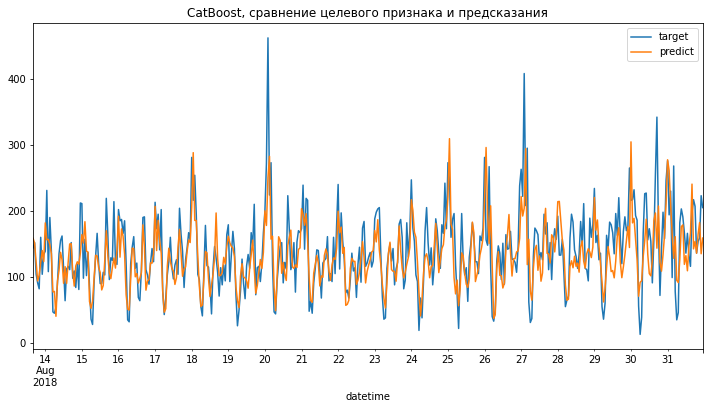

In [ ]:
# Построим график
cat_plot = pd.DataFrame({"target": y_test, "predict": predictions_cat})
cat_plot.plot(title = 'CatBoost, сравнение целевого признака и предсказания', figsize=(12, 6));

На графике видно, что в целом модель неплохо предсказывает спрос на услуги такси и его направление (понижение/повышение спроса), однако самые острые пики на графике (резкий краткосрочный всплекс спроса и резкое падение) так и остались не предсказанными.

## Итоговый вывод

- в данном проекте было обучено 5 моделей;
- качество моделей измерялось метрикой RMSE;
- наименьшее значение RMSE на кросс-валидации показала модель CatBoost с гиперпараметрами: learning_rate=0.25, iterations=250, depth=3;
- лучшая модель была проверена на тестовой выборке и показала значение RMSE в размере 42,623;
- в сравнении с константной моделью выбранная модель показывает существенно более хороший результат (RMSE константной модели = 58,882).  